# Integrated analysis and summrization

### summrize raw data for the following analysis

Ensure the targeted hubs' followe size exceeds 100 (otherwise the run should stop in step 20000)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import yaml
import json
import hashlib
from scipy import stats
import networkx as nx
import xml.etree.ElementTree as ET


RESULTS_DIR = "./results"
SUMMARY_ROOT = "./results/summary"
TARGET_STEPS = [0, 20000, 40000]
BINS = ["bin_0", "bin_1", "bin_2", "bin_3", "bin_4"]

TARGET_SEEDS = [0, 1, 2, 3, 4]

DEFAULT_TARGET = 1

def load_yaml_manual(fpath):
    config = {}
    current_section = None
    try:
        with open(fpath, 'r') as f:
            for line in f:
                raw_line = line.rstrip()
                line = raw_line.strip()
                if not line or line.startswith('#'): continue
                indent_level = len(raw_line) - len(line)
                if ':' in line:
                    key, val = line.split(':', 1)
                    key = key.strip()
                    val = val.strip().split('#')[0].strip()
                    if val.isdigit(): val = int(val)
                    elif val.replace('.','',1).isdigit(): val = float(val)
                    elif val.lower() == 'true': val = True
                    elif val.lower() == 'false': val = False
                    elif val.startswith('"') and val.endswith('"'): val = val[1:-1]
                    if indent_level == 0:
                        if not val: 
                            current_section = key
                            config[current_section] = {}
                        else:
                            config[key] = val
                            current_section = None
                    else:
                        if current_section:
                            config[current_section][key] = val
    except Exception as e: pass
    return config

def robust_read_gexf(fpath):
    try:
        tree = ET.parse(fpath)
        root = tree.getroot()
        for elem in root.iter():
            if '}' in elem.tag: elem.tag = elem.tag.split('}', 1)[1]
        G = nx.DiGraph()
        for node in root.findall(".//node"): G.add_node(node.get("id"))
        for edge in root.findall(".//edge"): G.add_edge(edge.get("source"), edge.get("target"))
        return G
    except: return None

def load_network_metrics(run_dir, step):
    gexf_pattern = os.path.join(run_dir, "GEXF", "*", f"step_{step}.gexf")
    files = glob.glob(gexf_pattern)
    metrics = {f"nw_step{step}_density": np.nan, f"nw_step{step}_clustering": np.nan, f"nw_step{step}_gamma": np.nan}
    if not files: return metrics

    try:
        G = robust_read_gexf(files[0])
        if G is None or len(G.nodes) == 0: return metrics
        
        # 1. Density
        metrics[f"nw_step{step}_density"] = nx.density(G)
        
        # 2. Clustering Coefficient
        G_und = G.to_undirected()
        metrics[f"nw_step{step}_clustering"] = nx.average_clustering(G_und)
        
        # 3. Scale-free Gamma
        degrees = [d for n, d in G.degree()]
        if len(degrees) > 10:
            k = np.array(degrees); k = k[k > 0]
            if len(k) > 10:
                hist, bins_edge = np.histogram(k, bins=15, density=True)
                centers = (bins_edge[:-1] + bins_edge[1:]) / 2
                valid = hist > 0
                if np.sum(valid) > 2:
                    slope, _, _, _, _ = stats.linregress(np.log(centers[valid]), np.log(hist[valid]))
                    metrics[f"nw_step{step}_gamma"] = -slope
    except: pass
    return metrics

def load_post_data_all_steps(run_dir):
    post_dir = os.path.join(run_dir, "posts")
    if not os.path.exists(post_dir): return pd.DataFrame()
    files = glob.glob(os.path.join(post_dir, "post_result_*.csv"))
    records = []
    for f in files:
        match = re.search(r"post_result_(\d+)\.csv", os.path.basename(f))
        if not match: continue
        step = int(match.group(1))
        try:
            df_temp = pd.read_csv(f)
            if df_temp.empty: continue
            row = df_temp.iloc[0]
            record = {"step": step}
            for b in BINS: record[b] = row.get(b, 0)
            records.append(record)
        except: pass
    return pd.DataFrame(records).sort_values("step") if records else pd.DataFrame()

# ==========================================
# 1. Processing (Data Extraction)
# ==========================================
def process_experiment_data_timeseries(window_size=100):
    config = {}
    runs = glob.glob(os.path.join(RESULTS_DIR, "run_*"))
    if runs:
        cfg_path = os.path.join(RESULTS_DIR, "config.yaml")
        if os.path.exists(cfg_path): config = load_yaml_manual(cfg_path)
    
    exclude_keys = ["start_seed", "end_seed", "num_seed", "target_opinion"]
    analysis_params = {k: v for k, v in config.items() if k not in exclude_keys}
    param_str = json.dumps(analysis_params, sort_keys=True, default=str)
    exp_id = hashlib.md5(param_str.encode()).hexdigest()[:8]
    
    topo = config.get("topology", "Unknown")
    net_p = config.get("network_params", {})
    net_str = "_".join([f"{k}_{net_p[k]}" for k in sorted(net_p.keys())]) if net_p else "default"
    
    dest_dir = os.path.join(SUMMARY_ROOT, topo, net_str, exp_id)
    os.makedirs(dest_dir, exist_ok=True)

    with open(os.path.join(dest_dir, "config.yaml"), 'w') as f:
        yaml.dump(config, f)
    
    global DEST_DIR
    DEST_DIR = dest_dir
    print(f"Processing data to: {dest_dir}")

    run_dirs = sorted(glob.glob(os.path.join(RESULTS_DIR, "run_*")))
    all_metrics = []
    
    timeseries_data = []

    for r_dir in run_dirs:
        run_name = os.path.basename(r_dir)
        try: seed_val = int(run_name.split("_")[1])
        except: seed_val = 0

        # only include seeds in "TARGET_SEEDS"
        if seed_val not in TARGET_SEEDS:
            continue
        
        print(f"Processing {run_name} (seed={seed_val})...")
        
        if run_name.endswith("_1.0"):
            target_sign = 1
        elif run_name.endswith("_-1.0"):
            target_sign = -1
        else:
            print(f"[Error] : target_sign not found in seed={seed_val}.")
        
        # 1. Network Metrics (Static Points)
        metrics = {"run_id": run_name, "seed": seed_val, "target_sign": target_sign}
        for step in TARGET_STEPS:
            metrics.update(load_network_metrics(r_dir, step))
        all_metrics.append(metrics)

        # 2. Post Data (Time Series)
        df_post = load_post_data_all_steps(r_dir)
        if not df_post.empty:
            # 100 step window average
            df_post = df_post.set_index('step').sort_index()
            df_post['window_idx'] = df_post.index // window_size
            df_agg = df_post.groupby('window_idx')[BINS].mean()
            df_agg['step'] = df_agg.index * window_size
            
            # Normalization
            mapping = {}
            if target_sign > 0:
                mapping = {
                    "target_extreme": "bin_4", "target_mod": "bin_3",
                    "neutral": "bin_2",
                    "opposite_mod": "bin_1", "opposite_extreme": "bin_0"
                }
            else:
                mapping = {
                    "target_extreme": "bin_0", "target_mod": "bin_1",
                    "neutral": "bin_2",
                    "opposite_mod": "bin_3", "opposite_extreme": "bin_4"
                }
            
            for rel_name, raw_bin in mapping.items():
                df_agg[rel_name] = df_agg[raw_bin]
            
            df_agg['run_id'] = run_name
            df_agg['seed'] = seed_val
            timeseries_data.append(df_agg)

    if not all_metrics:
        print("No metrics found.")
        return None, None, None

    # Save Network Metrics
    df_nw = pd.DataFrame(all_metrics)
    df_nw.to_csv(os.path.join(dest_dir, "network_metrics.csv"), index=False)
    
    # Save Time Series Data
    if timeseries_data:
        df_ts = pd.concat(timeseries_data, ignore_index=True)

        cols = ['run_id', 'seed', 'step', 'target_extreme', 'target_mod', 'neutral', 'opposite_mod', 'opposite_extreme']
        df_ts = df_ts[cols]
        df_ts.to_csv(os.path.join(dest_dir, "post_timeseries.csv"), index=False)
    else:
        df_ts = None

    print("✅ Data processed and saved.")
    return df_nw, df_ts, dest_dir


df_nw, df_ts, dest_dir = process_experiment_data_timeseries(window_size=100)

Processing data to: ./results/summary/CNNR/p_0.3_r_0.01/93235375
Processing run_12_dir_-1.0 (seed=12)...
Processing run_12_dir_1.0 (seed=12)...
Processing run_13_dir_-1.0 (seed=13)...
Processing run_13_dir_1.0 (seed=13)...
Processing run_29_dir_-1.0 (seed=29)...
Processing run_29_dir_1.0 (seed=29)...
Processing run_31_dir_-1.0 (seed=31)...
Processing run_31_dir_1.0 (seed=31)...
Processing run_41_dir_-1.0 (seed=41)...
Processing run_41_dir_1.0 (seed=41)...
Processing run_44_dir_-1.0 (seed=44)...
Processing run_44_dir_1.0 (seed=44)...
Processing run_46_dir_-1.0 (seed=46)...
Processing run_46_dir_1.0 (seed=46)...
Processing run_53_dir_-1.0 (seed=53)...
Processing run_53_dir_1.0 (seed=53)...
Processing run_54_dir_-1.0 (seed=54)...
Processing run_54_dir_1.0 (seed=54)...
Processing run_7_dir_-1.0 (seed=7)...
Processing run_7_dir_1.0 (seed=7)...
✅ Data processed and saved.


### visualize some summarized data and save the figures

1. change in posting ratio


==================== Diff Analysis (Comparison) ====================
Hypothesis: Target Increase < Opposite Increase (One-sided)
Sample Size (Seeds): 10
Mean Target Inc  : 5.0894
Mean Opposite Inc: 6.8058
Diff (Tar - Opp) : -1.7164
t-statistic      : -2.6594
p-value          : 0.013035
Result           : * (Significant at 5%)

-> Test result saved to: ./results/summary/CNNR/p_0.3_r_0.01/93235375/statistical_tests_log.txt


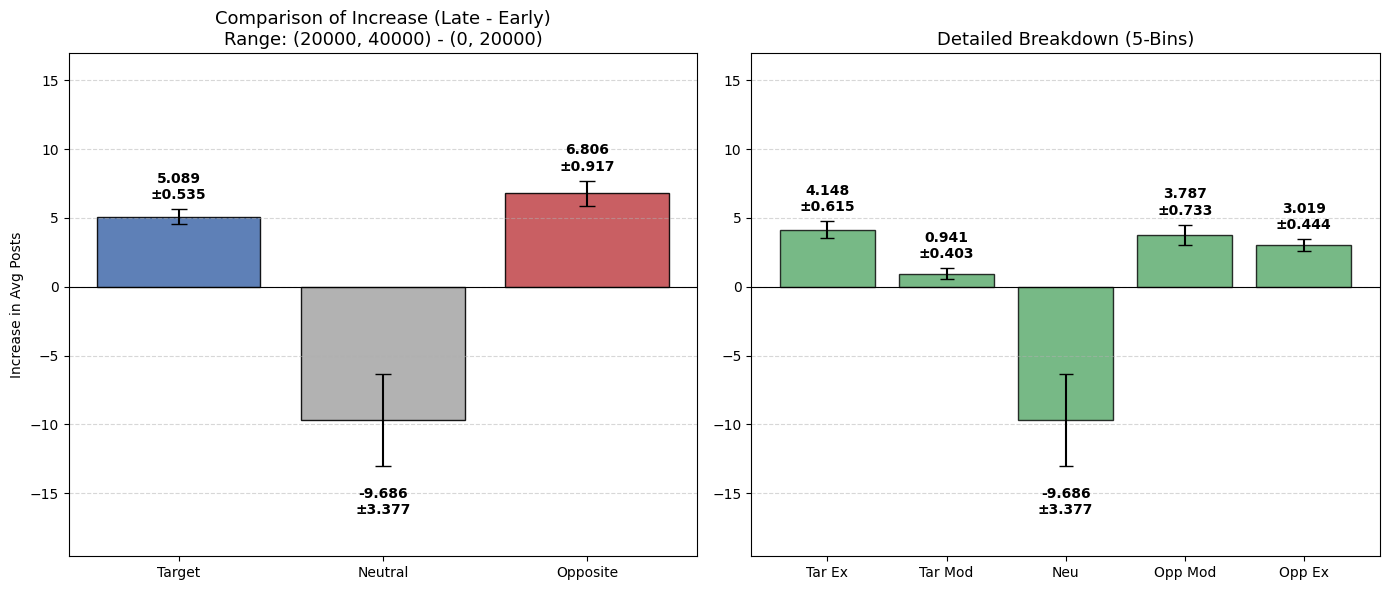


==================== Combined Increase Analysis ====================
Hypothesis: Target Increase < Opposite Increase (One-sided)
Sample Size (Seeds): 10
Mean Target Inc  : 4.1850
Mean Opposite Inc: 7.9564
Diff (Tar - Opp) : -3.7714
t-statistic      : -3.4786
p-value          : 0.003477
Result           : ** (Significant at 1%)

-> Test result saved to: ./results/summary/CNNR/p_0.3_r_0.01/93235375/statistical_tests_log.txt


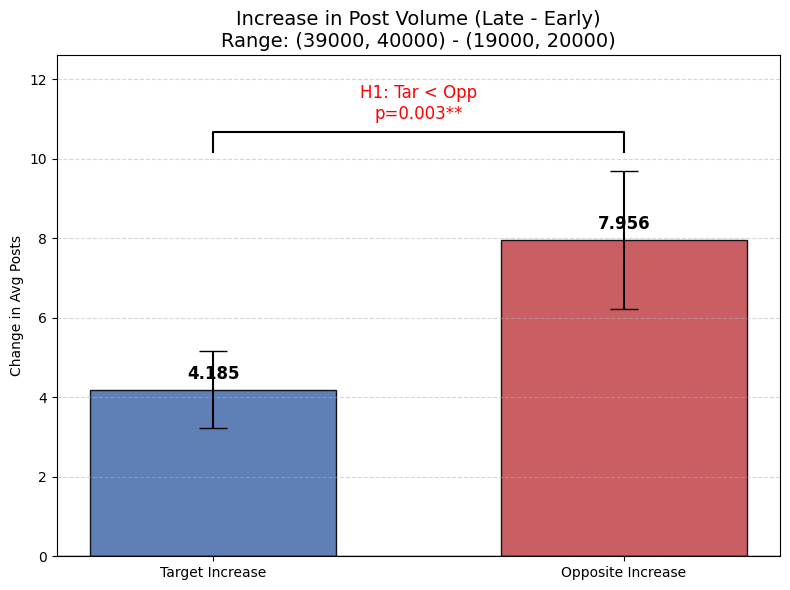

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats

# ==========================================
# Helper Functions
# ==========================================
def _get_means_by_seed(df_ts, range_tuple):
    if df_ts is None or df_ts.empty: return None
    mask = (df_ts['step'] >= range_tuple[0]) & (df_ts['step'] <= range_tuple[1])
    df_sub = df_ts.loc[mask]
    cols = ['target_extreme', 'target_mod', 'neutral', 'opposite_mod', 'opposite_extreme']
    return df_sub.groupby('seed')[cols].mean()

def _load_ts_if_needed(df_ts, dest_dir):
    if df_ts is None and dest_dir:
        csv_path = os.path.join(dest_dir, "post_timeseries.csv")
        if os.path.exists(csv_path): return pd.read_csv(csv_path)
    return df_ts

def _print_test_result(name, t_stat, p_val, mean_tar, mean_opp, n):
    print(f"\n{'='*20} {name} {'='*20}")
    print(f"Hypothesis: Target Increase < Opposite Increase (One-sided)")
    print(f"Sample Size (Seeds): {n}")
    print(f"Mean Target Inc  : {mean_tar:.4f}")
    print(f"Mean Opposite Inc: {mean_opp:.4f}")
    print(f"Diff (Tar - Opp) : {mean_tar - mean_opp:.4f}")
    print(f"t-statistic      : {t_stat:.4f}")
    print(f"p-value          : {p_val:.6f}")
    
    sig = ""
    if p_val < 0.01: sig = "** (Significant at 1%)"
    elif p_val < 0.05: sig = "* (Significant at 5%)"
    else: sig = "n.s. (Not Significant)"
    print(f"Result           : {sig}")
    print("="*60 + "\n")

def _save_and_print_test_result(dest_dir, name, t_stat, p_val, mean_tar, mean_opp, n):
    sig = ""
    if p_val < 0.01: sig = "** (Significant at 1%)"
    elif p_val < 0.05: sig = "* (Significant at 5%)"
    else: sig = "n.s. (Not Significant)"

    result_str = (
        f"\n{'='*20} {name} {'='*20}\n"
        f"Hypothesis: Target Increase < Opposite Increase (One-sided)\n"
        f"Sample Size (Seeds): {n}\n"
        f"Mean Target Inc  : {mean_tar:.4f}\n"
        f"Mean Opposite Inc: {mean_opp:.4f}\n"
        f"Diff (Tar - Opp) : {mean_tar - mean_opp:.4f}\n"
        f"t-statistic      : {t_stat:.4f}\n"
        f"p-value          : {p_val:.6f}\n"
        f"Result           : {sig}\n"
        f"{'='*60}\n"
    )

    print(result_str)

    if dest_dir:
        save_path = os.path.join(dest_dir, "statistical_tests_log.txt")
        try:
            with open(save_path, "a", encoding="utf-8") as f:
                f.write(result_str)
            print(f"-> Test result saved to: {save_path}")
        except Exception as e:
            print(f"[Warning] Failed to save test result: {e}")

# ==========================================
# 1. Diff Analysis (With Value Labels)
# ==========================================
def visualize_impact_diff(df_ts=None, dest_dir=None, 
                          range_early=(0, 20000), range_late=(20000, 40000)):
    df_ts = _load_ts_if_needed(df_ts, dest_dir)
    if df_ts is None or df_ts.empty: return

    mean_early = _get_means_by_seed(df_ts, range_early)
    mean_late = _get_means_by_seed(df_ts, range_late)
    diff_values = mean_late - mean_early 

    groups_3 = {
        "Target": ["target_extreme", "target_mod"],
        "Neutral": ["neutral"],
        "Opposite": ["opposite_extreme", "opposite_mod"]
    }
    
    target_inc = diff_values[groups_3["Target"]].sum(axis=1)
    neutral_inc = diff_values[groups_3["Neutral"]].sum(axis=1)
    opposite_inc = diff_values[groups_3["Opposite"]].sum(axis=1)
    
    t_stat, p_val = stats.ttest_rel(target_inc, opposite_inc, alternative='less')
    
    _save_and_print_test_result(dest_dir, "Diff Analysis (Comparison)", t_stat, p_val, 
                                target_inc.mean(), opposite_inc.mean(), len(target_inc))

    # --- Plotting ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    colors = ['#4c72b0', '#aaaaaa', '#c44e52']
    
    def add_value_labels(ax, rects, errs):
        y_min, y_max = ax.get_ylim()
        
        for rect, err in zip(rects, errs):
            height = rect.get_height()
            
            if height >= 0:
                y_pos = height + err
                va = 'bottom'
                offset = 5
            else:
                y_pos = height - err
                va = 'top'
                offset = -15
            
            label = f"{height:.3f}\n±{err:.3f}"
            
            ax.annotate(label,
                        xy=(rect.get_x() + rect.get_width() / 2, y_pos),
                        xytext=(0, offset),
                        textcoords="offset points",
                        ha='center', va=va, fontsize=10, fontweight='bold')
            
    # === Plot 1: 3-Bins ===
    ax = axes[0]
    means = [target_inc.mean(), neutral_inc.mean(), opposite_inc.mean()]
    sems = [target_inc.sem(), neutral_inc.sem(), opposite_inc.sem()]
    labels = ["Target", "Neutral", "Opposite"]
    
    bars1 = ax.bar(labels, means, yerr=sems, capsize=6, color=colors, edgecolor='black', alpha=0.9)
    
    add_value_labels(ax, bars1, sems)

    ax.set_title(f"Comparison of Increase (Late - Early)\nRange: {range_late} - {range_early}", fontsize=13)
    ax.set_ylabel("Increase in Avg Posts")
    ax.axhline(0, color='black', linewidth=0.8)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    y_abs_max = max([abs(m) + s for m, s in zip(means, sems)])
    ax.set_ylim(-y_abs_max*1.5 if min(means)<0 else -y_abs_max*0.1, y_abs_max*1.3)


    # === Plot 2: 5-Bins ===
    ax = axes[1]
    cols_5 = ["target_extreme", "target_mod", "neutral", "opposite_mod", "opposite_extreme"]
    labels_5 = ["Tar Ex", "Tar Mod", "Neu", "Opp Mod", "Opp Ex"]
    
    means_5, sems_5 = [], []
    for c in cols_5:
        vals = diff_values[c]
        means_5.append(vals.mean()); sems_5.append(vals.sem())
        
    bars2 = ax.bar(labels_5, means_5, yerr=sems_5, capsize=5, color='#55a868', edgecolor='black', alpha=0.8)
    
    add_value_labels(ax, bars2, sems_5)

    ax.set_title("Detailed Breakdown (5-Bins)", fontsize=13)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    y_abs_max_5 = max([abs(m) + s for m, s in zip(means_5, sems_5)])
    ax.set_ylim(-y_abs_max_5*1.5 if min(means_5)<0 else -y_abs_max_5*0.1, y_abs_max_5*1.3)

    plt.tight_layout()
    if dest_dir:
        plt.savefig(os.path.join(dest_dir, "plot_impact_diff.png"), dpi=300)
    plt.show()

# ==========================================
# 2. Combined Increase Analysis
# ==========================================
def visualize_impact_increase_combined(df_ts=None, dest_dir=None, 
                                       range_early=(19000, 20000), range_late=(39000, 40000)):
    df_ts = _load_ts_if_needed(df_ts, dest_dir)
    if df_ts is None or df_ts.empty: return

    mean_early = _get_means_by_seed(df_ts, range_early)
    mean_late = _get_means_by_seed(df_ts, range_late)
    diff_values = mean_late - mean_early
    
    groups_3 = {
        "Target": ["target_extreme", "target_mod"],
        "Opposite": ["opposite_extreme", "opposite_mod"]
    }
    
    target_inc = diff_values[groups_3["Target"]].sum(axis=1)
    opposite_inc = diff_values[groups_3["Opposite"]].sum(axis=1)

    t_stat, p_val = stats.ttest_rel(target_inc, opposite_inc, alternative='less')
    
    _save_and_print_test_result(dest_dir, "Combined Increase Analysis", t_stat, p_val, 
                                target_inc.mean(), opposite_inc.mean(), len(target_inc))
    
    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(8, 6))
    
    means = [target_inc.mean(), opposite_inc.mean()]
    sems = [target_inc.sem(), opposite_inc.sem()]
    labels = ["Target Increase", "Opposite Increase"]
    colors = ['#4c72b0', '#c44e52']
    
    bars = ax.bar(labels, means, yerr=sems, capsize=10, 
                  color=colors, alpha=0.9, edgecolor='black', width=0.6)
    
    for bar in bars:
        height = bar.get_height()
        offset = 5 if height >= 0 else -15
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, offset),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    sig_text = f"p={p_val:.3f}"
    if p_val < 0.01: sig_text += "**"
    elif p_val < 0.05: sig_text += "*"
    
    y_max = max(max(means) + max(sems), 0)

    if y_max == 0: y_max = max(means) 
    
    h = 0.05 * (y_max if y_max > 0 else 1.0) 
    line_pos = y_max + h
    
    ax.plot([0, 0, 1, 1], [line_pos, line_pos+h, line_pos+h, line_pos], lw=1.5, c='black')
    ax.text(0.5, line_pos + h*1.5, f"H1: Tar < Opp\n{sig_text}", 
            ha='center', va='bottom', fontsize=12, color='red')

    ax.set_ylim(top=line_pos + h*5)

    ax.set_title(f"Increase in Post Volume (Late - Early)\nRange: {range_late} - {range_early}", fontsize=14)
    ax.set_ylabel("Change in Avg Posts")
    ax.axhline(0, color='black', linewidth=1.0)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    if dest_dir:
        plt.savefig(os.path.join(dest_dir, "plot_impact_increase_combined.png"), dpi=300)
    plt.show()


if __name__ == "__main__":
    if 'df_ts' in locals() and 'dest_dir' in locals():

        visualize_impact_diff(
            df_ts, dest_dir, 
            range_early=(0, 20000), range_late=(20000, 40000)
        )

        visualize_impact_increase_combined(
            df_ts, dest_dir,
            range_early=(19000, 20000), range_late=(39000, 40000)
        )

2. change in network stats

Metrics found: ['clustering', 'density', 'gamma']
Steps found: [0, 20000, 40000]
📊 Plot saved to: ./results/summary/CNNR/p_0.3_r_0.01/93235375/plot_network_evolution.png


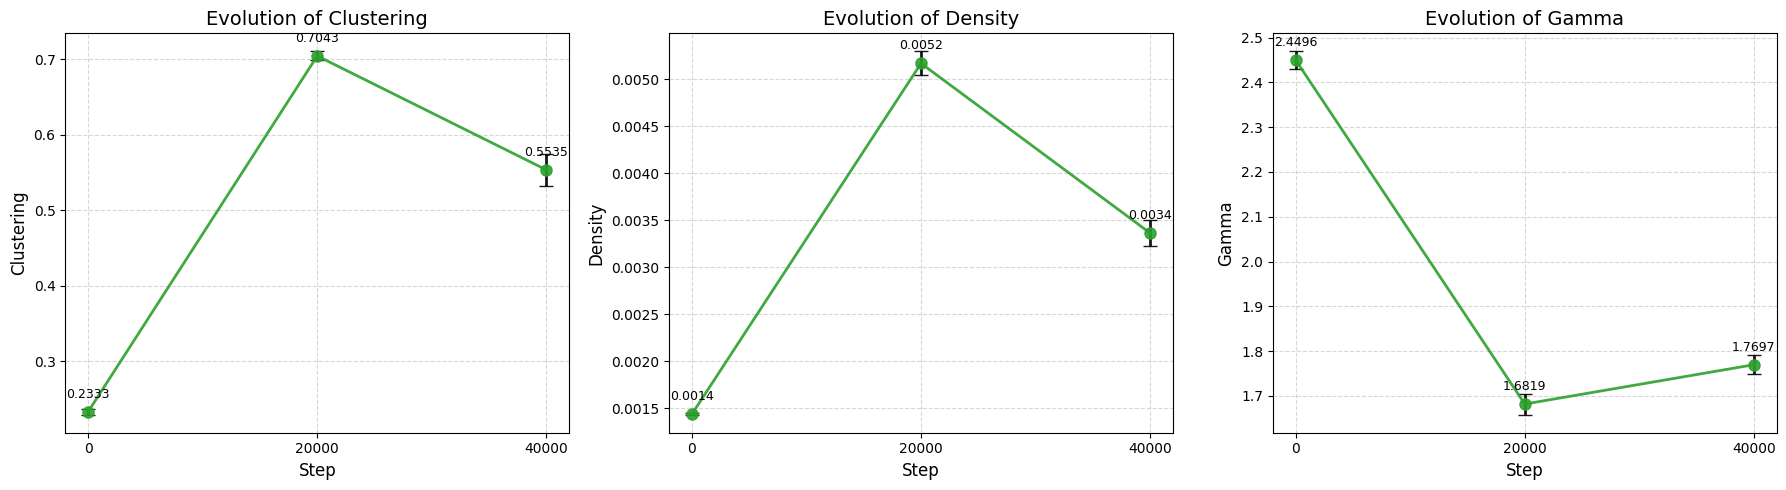

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# ==========================================
# Visualization: Network Metrics Evolution
# ==========================================
def visualize_network_evolution(df_nw=None, dest_dir=None):
    if df_nw is None and dest_dir:
        csv_path = os.path.join(dest_dir, "network_metrics.csv")
        if os.path.exists(csv_path):
            df_nw = pd.read_csv(csv_path)
    
    if df_nw is None or df_nw.empty:
        print("Error: No Network Metrics DataFrame available.")
        return

    steps = set()
    metrics = set()
    
    pattern = re.compile(r"nw_step(\d+)_(\w+)")
    for col in df_nw.columns:
        match = pattern.match(col)
        if match:
            steps.add(int(match.group(1)))
            metrics.add(match.group(2))
            
    sorted_steps = sorted(list(steps))
    sorted_metrics = sorted(list(metrics)) # density, clustering, gamma etc.
    
    if not sorted_steps:
        print("Error: No step columns found in DataFrame.")
        return

    print(f"Metrics found: {sorted_metrics}")
    print(f"Steps found: {sorted_steps}")
    
    plot_data = {} # {metric: {'means': [], 'sems': []}}
    
    for metric in sorted_metrics:
        means = []
        sems = []
        for step in sorted_steps:
            col_name = f"nw_step{step}_{metric}"
            if col_name in df_nw.columns:
                vals = df_nw[col_name].dropna()
                means.append(vals.mean())
                sems.append(vals.sem())
            else:
                means.append(np.nan)
                sems.append(np.nan)
        
        plot_data[metric] = {'means': means, 'sems': sems}

    num_metrics = len(sorted_metrics)
    fig, axes = plt.subplots(1, num_metrics, figsize=(6 * num_metrics, 5))
    
    if num_metrics == 1: axes = [axes] 
    
    for i, metric in enumerate(sorted_metrics):
        ax = axes[i]
        data = plot_data[metric]
        
        ax.errorbar(sorted_steps, data['means'], yerr=data['sems'], 
                    fmt='-o', capsize=5, markersize=8, linewidth=2, 
                    color='#2ca02c', ecolor='black', alpha=0.9)
        
        ax.set_title(f"Evolution of {metric.capitalize()}", fontsize=14)
        ax.set_xlabel("Step", fontsize=12)
        ax.set_ylabel(metric.capitalize(), fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.5)
        
        ax.set_xticks(sorted_steps)
        
        for x, y in zip(sorted_steps, data['means']):
            if pd.notna(y):
                ax.annotate(f"{y:.4f}", (x, y), textcoords="offset points", 
                            xytext=(0, 10), ha='center', fontsize=9)

    plt.tight_layout()
    
    if dest_dir:
        save_path = os.path.join(dest_dir, "plot_network_evolution.png")
        plt.savefig(save_path, dpi=300)
        print(f"📊 Plot saved to: {save_path}")
    
    plt.show()


if __name__ == "__main__":
    if 'df_nw' in locals() and 'dest_dir' in locals():
        visualize_network_evolution(df_nw, dest_dir)
    elif 'dest_dir' in locals():
        visualize_network_evolution(None, dest_dir)
    else:
        print("Please run data processing first to define 'dest_dir'.")

### for one side targeted experiments analysis in timeseries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re


RESULTS_DIR = "./results"      
WINDOW_SIZE = 100              
MAX_INDEX = 40000                

SEED_START = 0
SEED_END = 4

target_sign = 1.0

# TARGET_SEEDS = [11, 12, 13] if you need

DEST_DIR = "./results/summary"
OUTPUT_DIR = DEST_DIR
os.makedirs(OUTPUT_DIR, exist_ok=True)

BINS = ["bin_0", "bin_1", "bin_2", "bin_3", "bin_4"] 
bin_labels = {
    "bin_0": "-1.0 ~ -0.6",
    "bin_1": "-0.6 ~ -0.2",
    "bin_2": "-0.2 ~  0.2",
    "bin_3": " 0.2 ~  0.6",
    "bin_4": " 0.6 ~  1.0"
}


target_run_dirs = []
all_dfs = []

for seed in range(SEED_START, SEED_END + 1):
    if seed not in TARGET_SEEDS:
            continue

    p = os.path.join(RESULTS_DIR, f"run_{seed}_dir_*")
    
    candidates = glob.glob(p)
    
    for path in candidates:
        if os.path.isdir(path):
            dirname = os.path.basename(path)
            try:

                target_val = float(dirname.split('_')[-1])

                if (target_sign > 0 and target_val > 0) or (target_sign < 0 and target_val < 0):
                    target_run_dirs.append(path)
                    
            except (ValueError, IndexError):

                pass

run_dirs = sorted(list(set(target_run_dirs)))

In [ ]:
def smooth_list(values, window_size):
    smoothed = []
    for i in range(0, len(values), window_size):
        window = values[i:i+window_size]
        if window:
            smoothed.append(sum(window) / len(window))
    return smoothed

def load_and_process_seed(seed_dir, seed_name):
    post_dir = os.path.join(seed_dir, "posts")
    if not os.path.exists(post_dir):
        print(f"Skipping {seed_name}: post folder not found.")
        return None

    files = glob.glob(os.path.join(post_dir, "post_result_*.csv"))
    
    step_file_map = {}
    for f in files:
        match = re.search(r"post_result_(\d+)\.csv", os.path.basename(f))
        if match:
            step = int(match.group(1))
            step_file_map[step] = f
    
    sorted_steps = sorted(step_file_map.keys())
    if MAX_INDEX is not None:
        sorted_steps = [s for s in sorted_steps if s <= MAX_INDEX]

    ratios = {b: [] for b in BINS}
    counts = []
    steps = []

    for step in sorted_steps:
        filepath = step_file_map[step]
        try:
            df_temp = pd.read_csv(filepath)
            
            if df_temp.empty:
                continue
                
            row = df_temp.iloc[0]
            
            if "sumOfPosts" in row:
                total_posts = int(row["sumOfPosts"])
            else:
                total_posts = sum([int(row.get(b, 0)) for b in BINS])
            
            current_ratios = {}
            if total_posts > 0:
                for b in BINS:
                    current_ratios[b] = int(row.get(b, 0)) / total_posts
            else:
                for b in BINS:
                    current_ratios[b] = 0.0

            for b in BINS:
                ratios[b].append(current_ratios[b])
            counts.append(total_posts)
            steps.append(step)

        except Exception as e:
            pass

    if not steps:
        return None

    smoothed_steps = steps[::WINDOW_SIZE]
    
    data = {"step": smoothed_steps}
    
    for b in BINS:
        data[b] = smooth_list(ratios[b], WINDOW_SIZE)
        
    data["sumOfPosts"] = smooth_list(counts, WINDOW_SIZE)
    
    min_len = min([len(v) for v in data.values()])
    for k in data.keys():
        data[k] = data[k][:min_len]

    df_seed = pd.DataFrame(data)
    df_seed["seed"] = seed_name
    return df_seed

Found 3 seed directories.
Aggregated data saved to ./results/summary


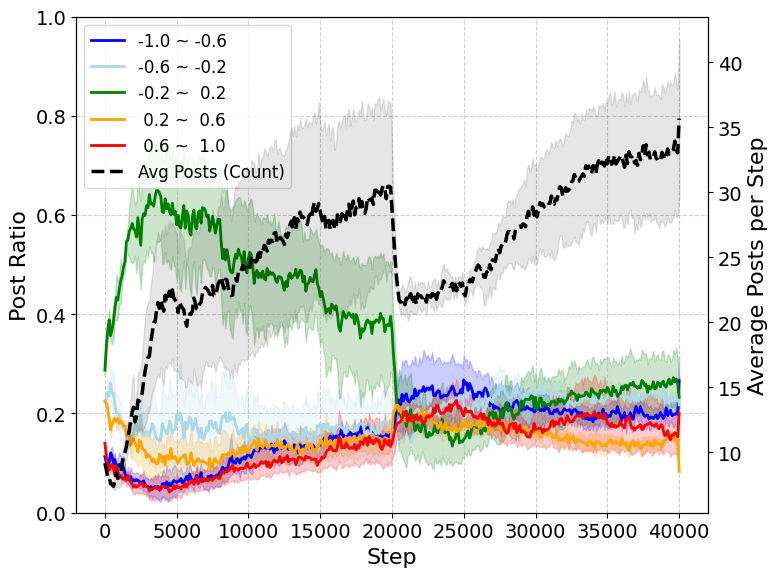

Plot generated.


In [ ]:
plt.rcParams['font.family'] = 'sans-serif'  
plt.rcParams['font.size'] = 14              
plt.rcParams['axes.labelsize'] = 16         
plt.rcParams['axes.titlesize'] = 18         
plt.rcParams['xtick.labelsize'] = 14        
plt.rcParams['ytick.labelsize'] = 14        
plt.rcParams['legend.fontsize'] = 12        
plt.rcParams['figure.figsize'] = (8, 6)   

# ==========================================
# main processing loop
# ==========================================

print(f"Found {len(run_dirs)} seed directories.")

for d in run_dirs:
    seed_name = os.path.basename(d)
    df = load_and_process_seed(d, seed_name)
    if df is not None:
        all_dfs.append(df)

if not all_dfs:
    print("No valid data found.")
else:
    full_df = pd.concat(all_dfs, ignore_index=True)
    
    grouped = full_df.groupby("step")
    df_mean = grouped.mean(numeric_only=True)
    df_se = grouped.sem(numeric_only=True)

    df_mean.to_csv(os.path.join(OUTPUT_DIR, "posts_mean_all_seeds.csv"))
    print(f"Aggregated data saved to {OUTPUT_DIR}")

    fig, ax1 = plt.subplots()

    steps = df_mean.index

    BIN_COLORS = ["blue", "lightblue", "green", "orange", "red"]

    for i, bin_name in enumerate(BINS):
        if bin_name in df_mean.columns:
            mean_val = df_mean[bin_name]
            se_val = df_se[bin_name]

            current_color = BIN_COLORS[i]
            
            label_text = bin_labels.get(bin_name, bin_name)
            
            ax1.plot(steps, mean_val, label=label_text, color=current_color, linewidth=2)
            
            ax1.fill_between(steps, 
                             mean_val - se_val, 
                             mean_val + se_val, 
                             color=current_color, alpha=0.2)

    ax1.set_xlabel("Step", fontsize=16)
    ax1.set_ylabel("Post Ratio", fontsize=16)
    ax1.set_ylim(0, 1.0)
    ax1.grid(True, linestyle="--", alpha=0.6)

    if "sumOfPosts" in df_mean.columns:
        ax2 = ax1.twinx()
        
        posts_mean = df_mean["sumOfPosts"]
        posts_se = df_se["sumOfPosts"]
        
        ax2.plot(steps, posts_mean, label="Avg Posts (Count)", color="black", linestyle="--", linewidth=2.5)
        
        ax2.fill_between(steps, 
                         posts_mean - posts_se, 
                         posts_mean + posts_se, 
                         color="black", alpha=0.1)
        
        ax2.set_ylabel("Average Posts per Step", fontsize=16)

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()

        ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(0, 1), loc='upper left')
    else:
        ax1.legend()

    plt.tight_layout()
    
    plt.savefig(os.path.join(OUTPUT_DIR, "post_analysis_plot.png"))
    plt.show()
    
    print("Plot generated.")

<Figure size 800x600 with 2 Axes>

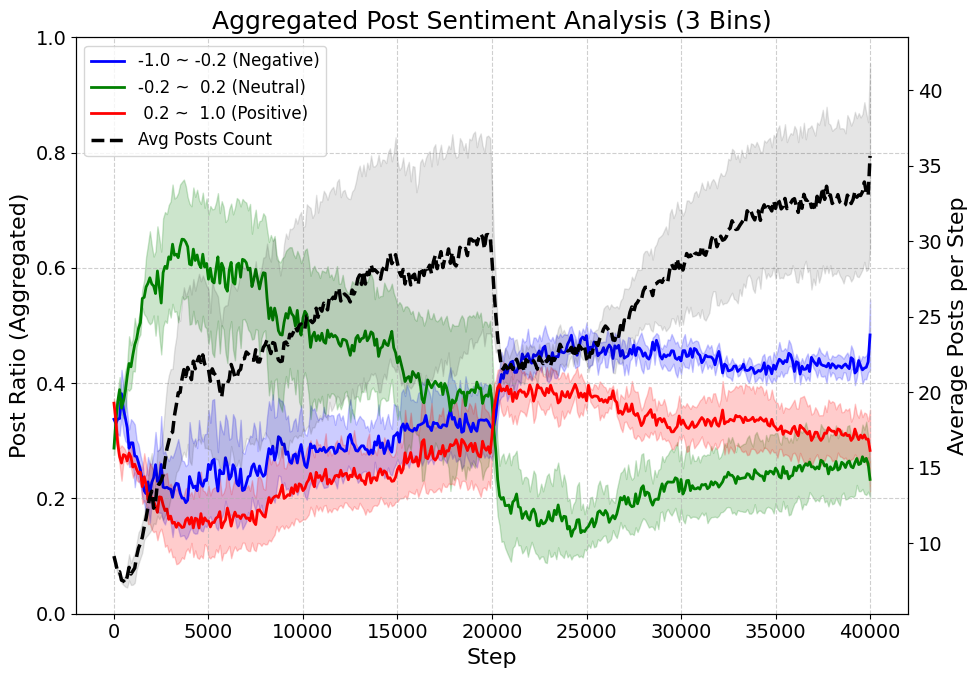

Plot generated successfully (3 bins integrated).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ==========================================
# Visualization: Aggregated Post Analysis (3 Bins Integrated)
# ==========================================

if 'all_dfs' in locals() and all_dfs:
    full_df = pd.concat(all_dfs, ignore_index=True)
    
    def safe_sum(df, cols):
        total = 0.0
        exists = False
        for c in cols:
            if c in df.columns:
                total += df[c]
                exists = True
        
        if not exists:
            return pd.Series(0.0, index=df.index)
        return total

    full_df['merged_neg'] = safe_sum(full_df, ['bin_0', 'bin_1']) # -1.0 ~ -0.2
    full_df['merged_neu'] = safe_sum(full_df, ['bin_2'])          # -0.2 ~  0.2
    full_df['merged_pos'] = safe_sum(full_df, ['bin_3', 'bin_4']) #  0.2 ~  1.0

    grouped = full_df.groupby("step")
    df_mean = grouped.mean(numeric_only=True)
    df_se = grouped.sem(numeric_only=True)

    fig, ax1 = plt.subplots(figsize=(10, 7))

    steps = df_mean.index
    
    MERGED_BINS = ['merged_neg', 'merged_neu', 'merged_pos']
    
    bin_labels = {
        "merged_neg": "-1.0 ~ -0.2 (Negative)",
        "merged_neu": "-0.2 ~  0.2 (Neutral)",
        "merged_pos": " 0.2 ~  1.0 (Positive)"
    }
    
    BIN_COLORS = ["blue", "green", "red"]

    for i, bin_name in enumerate(MERGED_BINS):
        if bin_name in df_mean.columns:
            mean_val = df_mean[bin_name]
            se_val = df_se[bin_name]

            current_color = BIN_COLORS[i]
            label_text = bin_labels.get(bin_name, bin_name)
            
            ax1.plot(steps, mean_val, label=label_text, color=current_color, linewidth=2)
            
            ax1.fill_between(steps, 
                             mean_val - se_val, 
                             mean_val + se_val, 
                             color=current_color, alpha=0.2)

    ax1.set_xlabel("Step", fontsize=16)
    ax1.set_ylabel("Post Ratio (Aggregated)", fontsize=16)
    ax1.set_ylim(0, 1.0)
    ax1.grid(True, linestyle="--", alpha=0.6)
    ax1.set_title("Aggregated Post Sentiment Analysis (3 Bins)", fontsize=18)

    if "sumOfPosts" in df_mean.columns:
        ax2 = ax1.twinx()
        
        posts_mean = df_mean["sumOfPosts"]
        posts_se = df_se["sumOfPosts"]
        
        ax2.plot(steps, posts_mean, label="Avg Posts Count", color="black", linestyle="--", linewidth=2.5)
        ax2.fill_between(steps, 
                         posts_mean - posts_se, 
                         posts_mean + posts_se, 
                         color="black", alpha=0.1)
        
        ax2.set_ylabel("Average Posts per Step", fontsize=16)

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(0, 1), loc='upper left')
    else:
        ax1.legend(loc='upper left')

    plt.tight_layout()
    
    save_dir = OUTPUT_DIR if 'OUTPUT_DIR' in locals() else '.'
    plt.savefig(os.path.join(save_dir, "post_analysis_3bins_fixed.png"))
    plt.show()
    
    print("Plot generated successfully (3 bins integrated).")

else:
    print("Error: 'all_dfs' is not defined. Please run the data loading code first.")